# 01 K-평균 알고리즘 이해

## K-평균을 이용한 붓꽃 데이터 세트 군집화

In [1]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()

irisDF = pd.DataFrame(data=iris.data, columns=['sepal_length','sepal_width','petal_length','petal_width'])
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [2]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(irisDF)

KMeans(n_clusters=3, random_state=0)

In [3]:
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [4]:
irisDF['target'] = iris.target
irisDF['cluster']=kmeans.labels_
iris_result = irisDF.groupby(['target','cluster'])['sepal_length'].count()
print(iris_result)

target  cluster
0       1          50
1       0          48
        2           2
2       0          14
        2          36
Name: sepal_length, dtype: int64


In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris.data)

irisDF['pca_x'] = pca_transformed[:,0]
irisDF['pca_y'] = pca_transformed[:,1]
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target,cluster,pca_x,pca_y
0,5.1,3.5,1.4,0.2,0,1,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,0,1,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,0,1,-2.888991,-0.144949


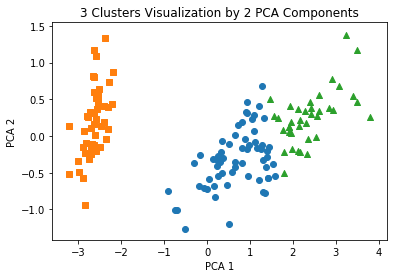

In [6]:
marker0_ind = irisDF[irisDF['cluster']==0].index
marker1_ind = irisDF[irisDF['cluster']==1].index
marker2_ind = irisDF[irisDF['cluster']==2].index

plt.scatter(x=irisDF.loc[marker0_ind,'pca_x'], y=irisDF.loc[marker0_ind,'pca_y'], marker='o') 
plt.scatter(x=irisDF.loc[marker1_ind,'pca_x'], y=irisDF.loc[marker1_ind,'pca_y'], marker='s')
plt.scatter(x=irisDF.loc[marker2_ind,'pca_x'], y=irisDF.loc[marker2_ind,'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

## 군집화 알고리즘 테스트를 위한 데이터 생성

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
%matplotlib inline

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.8, random_state=0)
print(X.shape, y.shape)

unique, counts = np.unique(y, return_counts=True)
print(unique,counts)

(200, 2) (200,)
[0 1 2] [67 67 66]


In [8]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
clusterDF.head(3)

,ftr1,ftr2,target
0,-1.692427,3.622025,2
1,0.697940,4.428867,0
2,1.100228,4.606317,0


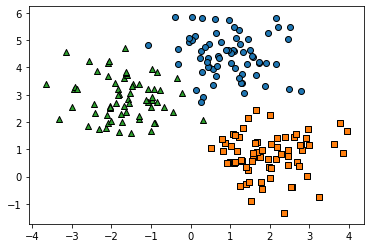

In [9]:
target_list = np.unique(y)

markers=['o', 's', '^', 'P','D','H','x']


for target in target_list:
    target_cluster = clusterDF[clusterDF['target']==target]
    plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'], edgecolor='k', marker=markers[target] )
plt.show()

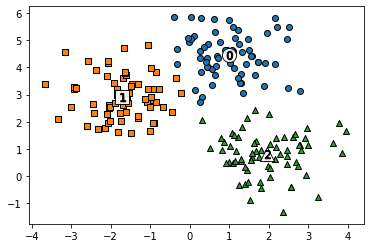

In [10]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=200, random_state=0)
cluster_labels = kmeans.fit_predict(X)
clusterDF['kmeans_label']  = cluster_labels

centers = kmeans.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'P','D','H','x']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['kmeans_label']==label]
    center_x_y = centers[label]
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', 
                marker=markers[label] )
    
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                alpha=0.9, edgecolor='k', marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                marker='$%d$' % label)

plt.show()

In [11]:
print(clusterDF.groupby('target')['kmeans_label'].value_counts())

target  kmeans_label
0       0               66
        1                1
1       2               67
2       1               65
        2                1
Name: kmeans_label, dtype: int64


# 02 군집 평가

## 붓꽃 데이터 세트를 이용한 군집 평가

In [12]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(irisDF)

irisDF['cluster'] = kmeans.labels_

score_samples = silhouette_samples(iris.data, irisDF['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

irisDF['silhouette_coeff'] = score_samples

average_score = silhouette_score(iris.data, irisDF['cluster'])
print('붓꽃 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))

irisDF.head(3)

silhouette_samples( ) return 값의 shape (150,)
붓꽃 데이터셋 Silhouette Analysis Score:0.553


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315


In [13]:
irisDF.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

## 군집별 평균 실루엣 계수의 시각화를 통한 군집 개수 최적화 방법

In [15]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

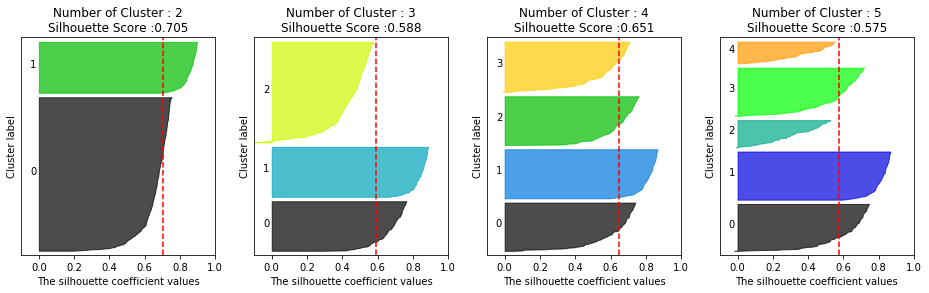

In [16]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

visualize_silhouette([ 2, 3, 4, 5], X)

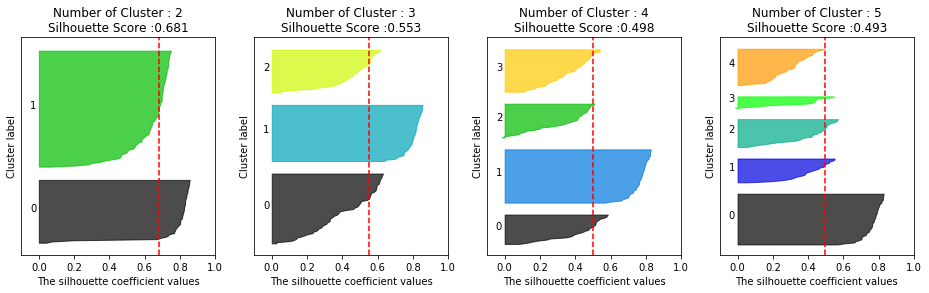

In [17]:
from sklearn.datasets import load_iris

iris=load_iris()
visualize_silhouette([ 2, 3, 4,5 ], iris.data)

# 03 평균 이동

## 평균 이동의 개요

In [18]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, 
                  cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [19]:
meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [20]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [21]:
import pandas as pd


clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

best_bandwidth = estimate_bandwidth(X)

meanshift= MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


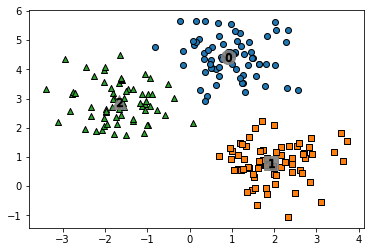

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]

    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label] )
    

    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)
    
plt.show()

In [23]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: meanshift_label, dtype: int64


# 03 GMM
## GMM을 이용한 붓꽃 데이터 세트 군집화